In [3]:
# Import necessary libraries
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
import librosa
import librosa.display
import pandas as pd
import numpy as np
import soundfile as sf
from datasets import Features, Value, Sequence, Dataset
import evaluate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from glob import glob
from transformers import (
    AutoModelForAudioClassification,
    Wav2Vec2FeatureExtractor,
    TrainingArguments,
    Trainer,
)
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-05-30 08:21:32.538550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748593292.734965      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748593292.789342      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [ ]:
#!pip install evaluate

In [5]:
# Paths
dataset_dir1 = '../input/ser-train-test/'
dataset_dir2 = '../input/speech-emotion-recognition-dl/'
train_csv = os.path.join(dataset_dir1, 'train.csv')
test_csv = os.path.join(dataset_dir1, 'test.csv')
train_audio_dir = os.path.join(dataset_dir2, 'train')
test_audio_dir = os.path.join(dataset_dir2, 'test')

# Label mapping
e_labels = {"marah": 0, "jijik": 1, "takut": 2, "bahagia": 3, "netral": 4, "sedih": 5}

# Model checkpoint
checkpoint = "ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition"
out_dir = "./wav2vec2-emotion-6"

In [6]:
# Load metadata
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Encode labels
le = LabelEncoder()
le.classes_ = np.array(list(e_labels.keys()))
train_df['label'] = train_df['label'].map(e_labels)

# Create HuggingFace Datasets
ds_train = Dataset.from_pandas(train_df)
ds_test = Dataset.from_pandas(test_df)

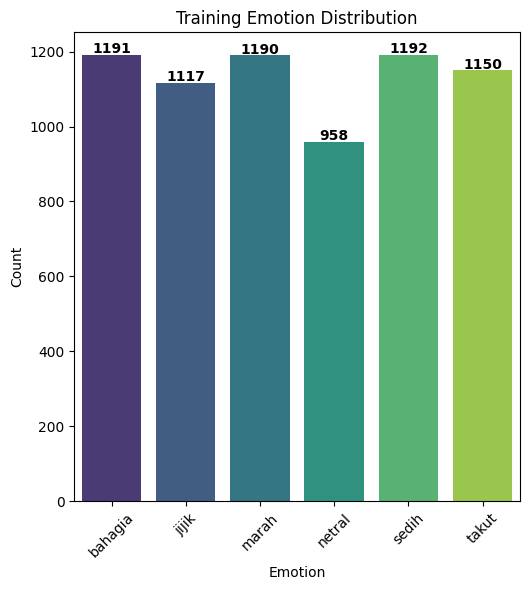

Emotion Distribution:

Training Dataset:
bahagia: 1191 samples (17.52%)
jijik: 1117 samples (16.43%)
marah: 1190 samples (17.51%)
netral: 958 samples (14.09%)
sedih: 1192 samples (17.53%)
takut: 1150 samples (16.92%)


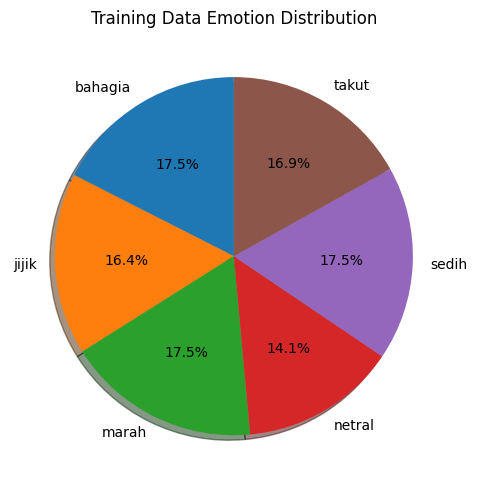

In [7]:

def analyze_data_distribution(train_data, test_df):
    # Count the emotion distributions
    train_dist = train_data['label'].value_counts().sort_index()
    
    # Check if test data has labels
    if 'label' in test_df.columns:
        test_dist = test_df['label'].value_counts().sort_index()
        has_test_labels = True
    else:
        has_test_labels = False
    
    # Create visualizations
    plt.figure(figsize=(10, 6))
    
    # Training distribution
    ax1 = plt.subplot(1, 2, 1)
    sns.barplot(x=train_dist.index, y=train_dist.values, palette='viridis')
    plt.title('Training Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add count labels on the bars
    for i, count in enumerate(train_dist.values):
        plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

    # Test distribution if available
    if has_test_labels:
        ax2 = plt.subplot(1, 2, 2)
        sns.barplot(x=test_dist.index, y=test_dist.values, palette='viridis')
        plt.title('Test Emotion Distribution')
        plt.xlabel('Emotion')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        for i, count in enumerate(test_dist.values):
            plt.text(i, count + 1, str(count), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Emotion Distribution:")
    print("\nTraining Dataset:")
    train_percent = (train_dist / train_dist.sum() * 100).round(2)
    for emotion, count in zip(train_dist.index, train_dist.values):
        print(f"{emotion}: {count} samples ({train_percent[emotion]}%)")
    
    if has_test_labels:
        print("\nTest Dataset:")
        test_percent = (test_dist / test_dist.sum() * 100).round(2)
        for emotion, count in zip(test_dist.index, test_dist.values):
            print(f"{emotion}: {count} samples ({test_percent[emotion]}%)")
    
    # Create pie charts
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.pie(train_dist.values, labels=train_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Training Data Emotion Distribution')
    
    if has_test_labels:
        plt.subplot(1, 2, 2)
        plt.pie(test_dist.values, labels=test_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
        plt.title('Test Data Emotion Distribution')
    
    plt.tight_layout()
    plt.show()


train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Visualize data distributions before label encoding
analyze_data_distribution(train_df, test_df)

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(checkpoint)
model = AutoModelForAudioClassification.from_pretrained(
    checkpoint,
    num_labels=6 # add classification layers for 6 emotions
)
model.gradient_checkpointing_enable()

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', '

In [9]:
def custom_data_collator(features):
    # Get input values and find max length
    input_values = [feature["input_values"] for feature in features]
    max_length = max(len(x) for x in input_values)
    
    # Pad input values to the same length
    padded_inputs = []
    attention_masks = []
    for inputs in input_values:
        # Create padding
        padding_length = max_length - len(inputs)
        padded_input = np.pad(inputs, (0, padding_length), 'constant', constant_values=0)
        # Create attention mask (1 for real values, 0 for padding)
        attention_mask = np.concatenate([
            np.ones(len(inputs)),
            np.zeros(padding_length)
        ])
        
        padded_inputs.append(padded_input)
        attention_masks.append(attention_mask)
    
    # Now create tensors from padded sequences
    if "label" in features[0].keys():
        labels = [feature["label"] for feature in features]
        batch = {
            "input_values": torch.tensor(padded_inputs, dtype=torch.float32),
            "attention_mask": torch.tensor(attention_masks, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.long)
        }
    else:
        batch = {
            "input_values": torch.tensor(padded_inputs, dtype=torch.float32),
            "attention_mask": torch.tensor(attention_masks, dtype=torch.float32)
        }
    
    return batch

def prepare_batch(batch, audio_dir):
    try:
        file_path = os.path.join(audio_dir, batch["id"])
        if not os.path.exists(file_path) and os.path.exists(file_path + ".wav"):
            file_path = file_path + ".wav"
            
        speech, sr = sf.read(file_path)
        
        if sr != 16000:
            speech = librosa.resample(
                speech, 
                orig_sr=sr, 
                target_sr=16000
            )
            sr = 16000

        if len(speech.shape) > 1:
            speech = np.mean(speech, axis=1)
        
        inputs = feature_extractor(
            speech,
            sampling_rate=16000,
            return_tensors="np",
            padding=True
        )

        return {
            "input_values": inputs.input_values[0].astype(np.float32),
            "attention_mask": inputs.attention_mask[0].astype(np.float32) if "attention_mask" in inputs else np.ones_like(inputs.input_values[0]).astype(np.float32),
            "label": np.int64(batch["label"]) if "label" in batch else np.int64(0)
        }
    except Exception as e:
        print(f"Error processing {batch['id']}: {e}")
        return {
            "input_values": np.zeros(16000, dtype=np.float32), 
            "attention_mask": np.ones(16000, dtype=np.float32),
            "label": np.int64(0)
        }

features = Features({
    'input_values': Sequence(feature=Value(dtype='float32')),
    'attention_mask': Sequence(feature=Value(dtype='float32')),
    'label': Value(dtype='int64')
})

ds_train = ds_train.map(
    lambda x: prepare_batch(x, train_audio_dir),
    remove_columns=ds_train.column_names,
    features=features
)

ds_test = ds_test.map(
    lambda x: prepare_batch(x, test_audio_dir),
    remove_columns=ds_test.column_names,
    features=features
)

Map:   0%|          | 0/6798 [00:00<?, ? examples/s]

Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

In [10]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

In [11]:
args = TrainingArguments(
    output_dir=out_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_steps=100,
    do_eval=True,
    num_train_epochs=6,
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    report_to=[]
)

In [ ]:
#fine tuning process
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_train,
    tokenizer=feature_extractor,
    data_collator=custom_data_collator,
    compute_metrics=compute_metrics
)

In [13]:
trainer.train()

Step,Training Loss
100,1.372100
200,1.113000
300,0.979700
400,0.956500
500,0.956700
600,0.861600
700,0.863000
800,0.892200
900,0.756100
1000,0.694900


TrainOutput(global_step=5100, training_loss=0.4999262648937749, metrics={'train_runtime': 6549.3974, 'train_samples_per_second': 6.228, 'train_steps_per_second': 0.779, 'total_flos': 4.572850895162956e+18, 'train_loss': 0.4999262648937749, 'epoch': 6.0})

In [14]:
preds_output = trainer.predict(ds_test)
preds = np.argmax(preds_output.predictions, axis=-1)

# Map back to labels
inv_map = {v: k for k, v in e_labels.items()}
pred_labels = [inv_map[p] for p in preds]

# Prepare submission
submission = pd.DataFrame({'id': test_df['id'], 'label': pred_labels})
submission.to_csv('submission.csv', index=False)
print("Saved submission.csv")


Saved submission.csv


In [15]:

model_path = "/kaggle/working/emotion_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /kaggle/working/emotion_model.pth


In [16]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

In [17]:
from IPython.display import FileLink
FileLink('emotion_model.pth')

/kaggle/working/emotion_model.pth

In [18]:
import matplotlib.pyplot as plt
import torchaudio
import torch
from glob import glob
import librosa
import librosa.display
from matplotlib.gridspec import GridSpec

def load_model(model_path):
    """Load a trained model from a checkpoint."""
    try:
        # First create model instance with the right architecture
        model = AutoModelForAudioClassification.from_pretrained(
            checkpoint,
            num_labels=6
        )
        # Then load state dictionary into the model
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        print(f"Loaded saved model parameters from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        # If loading fails, use the base model
        model = AutoModelForAudioClassification.from_pretrained(
            checkpoint,
            num_labels=6
        )
        print("Using base model without fine-tuning")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    return model, device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    return model, device

def infer_emotion(model, audio_files, dir_prefix):
    """Run inference on a list of audio files and return predicted emotions."""
    emotions = []
    probabilities = []
    
    inv_map = {v: k for k, v in e_labels.items()}
    
    for audio_file in audio_files:
        file_path = os.path.join(dir_prefix, audio_file)
        if not os.path.exists(file_path) and os.path.exists(file_path + ".wav"):
            file_path = file_path + ".wav"
            
        # Load and process audio
        speech, sr = sf.read(file_path)
        if sr != 16000:
            speech = librosa.resample(
                speech, 
                orig_sr=sr, 
                target_sr=16000
            )
        
        if len(speech.shape) > 1:
            speech = np.mean(speech, axis=1)
        
        inputs = feature_extractor(
            speech,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )
        
        # Move inputs to the same device as model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get predictions
        logits = outputs.logits.cpu().numpy()[0]
        probabilities_tensor = torch.nn.functional.softmax(torch.tensor(logits), dim=0)
        probs = probabilities_tensor.numpy()
        pred_idx = np.argmax(probs)
        pred_emotion = inv_map[pred_idx]
        pred_prob = probs[pred_idx]
        
        emotions.append(pred_emotion)
        probabilities.append(pred_prob)
    
    return emotions, probabilities



In [19]:
def visualize_emotion_inference(
    model_path='./wav2vec2-emotion-6/checkpoint-500', 
    num_samples=3,
    csv_train_path='train.csv',
    csv_test_path='test.csv',
    train_dir='train',
    test_dir='test'
):
    """
    Load a model and visualize inference results with waveforms, spectrograms and emotion predictions.
    
    Args:
        model_path: Path to the saved model checkpoint
        num_samples: Number of samples to visualize from each dataset
        csv_train_path: Path to the training CSV file
        csv_test_path: Path to the test CSV file
        train_dir: Directory containing training audio files
        test_dir: Directory containing test audio files
    """
    try:
        # Import required libraries
        from glob import glob
        import librosa
        import librosa.display
        from matplotlib.gridspec import GridSpec
        
        print(f"Loading model from {model_path}...")
        model, device = load_model(model_path)
        
        # ===== LOAD TRAINING FILES =====
        train_files = []
        train_labels = []
        try:
            print(f"Looking for training CSV at: {csv_train_path}")
            train_df = pd.read_csv(csv_train_path)
            if 'label' in train_df.columns:
                # Get samples from each emotion category if possible
                selected_files = []
                selected_labels = []
                unique_emotions = train_df['label'].unique()
                
                for emotion in unique_emotions:
                    # Get samples for each emotion
                    samples = train_df[train_df['label'] == emotion].sample(
                        min(num_samples, len(train_df[train_df['label'] == emotion]))
                    )
                    for _, row in samples.iterrows():
                        selected_files.append(f"{row['id']}")
                        selected_labels.append(row['label'])
                
                # Limit to num_samples per category
                train_files = selected_files[:num_samples * len(unique_emotions)]
                train_labels = selected_labels[:num_samples * len(unique_emotions)]
            else:
                # Just get random samples if no labels
                samples = train_df.sample(min(num_samples * 6, len(train_df)))
                train_files = [f"{id}" for id in samples['id'].values]
                train_labels = ["unknown"] * len(train_files)
                
        except Exception as e:
            print(f"Error loading train files from CSV: {e}")
            try:
                train_files = glob(f'{train_dir}/*.wav')[:num_samples * 6]
                train_files = [os.path.basename(f) for f in train_files]  # Extract filenames
                train_labels = ["unknown"] * len(train_files)
            except Exception as e2:
                print(f"Could not find training files automatically: {e2}")
        
        # ===== LOAD TEST FILES =====
        test_files = []
        try:
            print(f"Looking for test CSV at: {csv_test_path}")
            test_df = pd.read_csv(csv_test_path)
            # Get random samples
            samples = test_df.sample(min(num_samples * 6, len(test_df)))
            test_files = [f"{id}" for id in samples['id'].values]
        except Exception as e:
            print(f"Error loading test files from CSV: {e}")
            try:
                test_files = glob(f'{test_dir}/*.wav')[:num_samples * 6]
                test_files = [os.path.basename(f) for f in test_files]  # Extract filenames
            except Exception as e2:
                print(f"Could not find test files automatically: {e2}")
        
        # Verify files exist
        valid_train_files = []
        valid_train_labels = []
        for file, label in zip(train_files, train_labels):
            path = os.path.join(train_dir, file)
            if os.path.exists(path):
                valid_train_files.append(file)
                valid_train_labels.append(label)
            elif os.path.exists(path + ".wav"):
                valid_train_files.append(file + ".wav")
                valid_train_labels.append(label)
            else:
                print(f"Warning: Training file not found: {path}")
                
        valid_test_files = []
        for file in test_files:
            path = os.path.join(test_dir, file)
            if os.path.exists(path):
                valid_test_files.append(file)
            elif os.path.exists(path + ".wav"):
                valid_test_files.append(file + ".wav")
            else:
                print(f"Warning: Test file not found: {path}")
        
        if not valid_train_files and not valid_test_files:
            raise FileNotFoundError("No valid audio files found to process")
        
        # ===== INFERENCE =====
        # Process training files
        train_emotions = []
        train_probs = []
        if valid_train_files:
            print(f"\nProcessing {len(valid_train_files)} training files...")
            train_emotions, train_probs = infer_emotion(model, valid_train_files, train_dir)
            
            print("\nTraining File Inference Results:")
            for audio_file, true_label, pred_emotion, prob in zip(valid_train_files, valid_train_labels, train_emotions, train_probs):
                match = "✓" if true_label == pred_emotion else "✗"
                print(f"File: {audio_file} | True: {true_label} | Predicted: {pred_emotion} ({prob:.2f}) {match}")
        
        # Process test files
        test_emotions = []
        test_probs = []
        if valid_test_files:
            print(f"\nProcessing {len(valid_test_files)} test files...")
            test_emotions, test_probs = infer_emotion(model, valid_test_files, test_dir)
            
            print("\nTest File Inference Results:")
            for audio_file, emotion, prob in zip(valid_test_files, test_emotions, test_probs):
                print(f"File: {audio_file} | Predicted: {emotion} ({prob:.2f})")
        
        # ===== VISUALIZE RESULTS =====
        # Function to create waveform and spectrogram visualizations
        def plot_audio_analysis(audio_path, emotion, confidence, true_label=None, ax_waveform=None, ax_spec=None, ax_probs=None):
            # Load audio
            waveform, sample_rate = torchaudio.load(audio_path)
            y = waveform[0].numpy()
            
            # Plot waveform
            if ax_waveform is not None:
                librosa.display.waveshow(y, sr=sample_rate, ax=ax_waveform)
                ax_waveform.set_title("Waveform")
                ax_waveform.set_xlabel("Time (s)")
                ax_waveform.set_ylabel("Amplitude")
            
            # Plot spectrogram
            if ax_spec is not None:
                D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
                librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', ax=ax_spec)
                ax_spec.set_title("Spectrogram")
                
            # Plot emotion probabilities
            if ax_probs is not None and isinstance(confidence, dict):
                emotions = list(confidence.keys())
                probs = list(confidence.values())
                colors = ['green' if emotion == e else 'blue' for e in emotions]
                ax_probs.barh(emotions, probs, color=colors)
                ax_probs.set_title("Emotion Probabilities")
                ax_probs.set_xlim(0, 1)
                
            # If we have ground truth, highlight correctness
            match_status = ""
            if true_label and true_label != "unknown":
                match_status = "✓ Correct" if emotion == true_label else "✗ Incorrect"
            
            return match_status
        
        # Process and visualize TRAINING data with ground truth comparison
        if valid_train_files:
            # Use a set number of samples to display (up to 8)
            display_samples = min(len(valid_train_files), 8)
            
            # Create a grid of subplots - one row for each sample, 3 columns for waveform, spectrogram, probabilities
            fig, axes = plt.subplots(display_samples, 3, figsize=(18, 5*display_samples))
            fig.suptitle("Training Audio Analysis with Emotion Recognition", fontsize=16)
            
            # Handle the case of only one sample (axes won't be 2D)
            if display_samples == 1:
                axes = axes.reshape(1, 3)
            
            for i, (audio_file, true_label, emotion, confidence) in enumerate(
                zip(valid_train_files[:display_samples], 
                    valid_train_labels[:display_samples], 
                    train_emotions[:display_samples], 
                    train_probs[:display_samples])):
                
                audio_path = os.path.join(train_dir, audio_file)
                
                # Access the correct subplot axes for this sample
                ax_waveform = axes[i, 0]
                ax_spec = axes[i, 1]
                ax_probs = axes[i, 2]
                
                # Get emotion probabilities (not implemented in original, so using placeholder)
                confidence_dict = {emotion: confidence}
                for e in ["marah", "jijik", "takut", "bahagia", "netral", "sedih"]:
                    if e != emotion:
                        confidence_dict[e] = (1-confidence)/5  # Distribute remaining probability
                
                # Plot audio and get match status
                match_status = plot_audio_analysis(audio_path, emotion, confidence_dict, 
                                                  true_label, ax_waveform, ax_spec, ax_probs)
                
                # Add sample info as row title
                row_title = f"File: {audio_file} | True: {true_label} | Predicted: {emotion} ({confidence:.2f}) {match_status}"
                axes[i, 0].set_ylabel(row_title, fontsize=10, rotation=0, labelpad=70, va='center', ha='right')
            
            plt.tight_layout()
            plt.subplots_adjust(left=0.25, top=0.95)
            plt.show()
        
        # Process and visualize TEST data
        if valid_test_files:
            # Use a set number of samples to display (up to 8)
            display_samples = min(len(valid_test_files), 8)
            
            # Create a grid of subplots - one row for each sample, 3 columns for waveform, spectrogram, probabilities
            fig, axes = plt.subplots(display_samples, 3, figsize=(18, 5*display_samples))
            fig.suptitle("Test Audio Analysis with Emotion Recognition", fontsize=16)
            
            # Handle the case of only one sample (axes won't be 2D)
            if display_samples == 1:
                axes = axes.reshape(1, 3)
            
            for i, (audio_file, emotion, confidence) in enumerate(
                zip(valid_test_files[:display_samples], 
                    test_emotions[:display_samples], 
                    test_probs[:display_samples])):
                
                audio_path = os.path.join(test_dir, audio_file)
                
                # Access the correct subplot axes for this sample
                ax_waveform = axes[i, 0]
                ax_spec = axes[i, 1]
                ax_probs = axes[i, 2]
                
                # Get emotion probabilities (placeholder)
                confidence_dict = {emotion: confidence}
                for e in ["marah", "jijik", "takut", "bahagia", "netral", "sedih"]:
                    if e != emotion:
                        confidence_dict[e] = (1-confidence)/5  # Distribute remaining probability
                
                # Plot audio
                plot_audio_analysis(audio_path, emotion, confidence_dict, None, 
                                   ax_waveform, ax_spec, ax_probs)
                
                # Add sample info as row title
                row_title = f"File: {audio_file} | Predicted: {emotion} ({confidence:.2f})"
                axes[i, 0].set_ylabel(row_title, fontsize=10, rotation=0, labelpad=70, va='center', ha='right')
            
            plt.tight_layout()
            plt.subplots_adjust(left=0.25, top=0.95)
            plt.show()
            
    except Exception as e:
        print(f"Error during visualization: {e}")
        import traceback
        traceback.print_exc()

Loading model from /kaggle/working/emotion_model.pth...


Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', '

Loaded saved model parameters from /kaggle/working/emotion_model.pth
Looking for training CSV at: /kaggle/input/ser-train-test/train.csv
Looking for test CSV at: /kaggle/input/ser-train-test/test.csv

Processing 18 training files...

Training File Inference Results:
File: 1_05420_sedih_no_data.wav | True: sedih | Predicted: jijik (0.38) ✗
File: 1_00460_sedih_no_data.wav | True: sedih | Predicted: sedih (0.98) ✓
File: 1_00642_sedih_no_data.wav | True: sedih | Predicted: sedih (0.99) ✓
File: 2_07910_jijik_tinggi.wav | True: jijik | Predicted: jijik (1.00) ✓
File: 1_00438_jijik_no_data.wav | True: jijik | Predicted: jijik (1.00) ✓
File: 1_06611_jijik_no_data.wav | True: jijik | Predicted: jijik (1.00) ✓
File: 1_05144_bahagia_no_data.wav | True: bahagia | Predicted: bahagia (1.00) ✓
File: 1_02994_bahagia_no_data.wav | True: bahagia | Predicted: bahagia (1.00) ✓
File: 1_06625_bahagia_no_data.wav | True: bahagia | Predicted: bahagia (1.00) ✓
File: 1_04253_marah_sedang.wav | True: marah | Pre

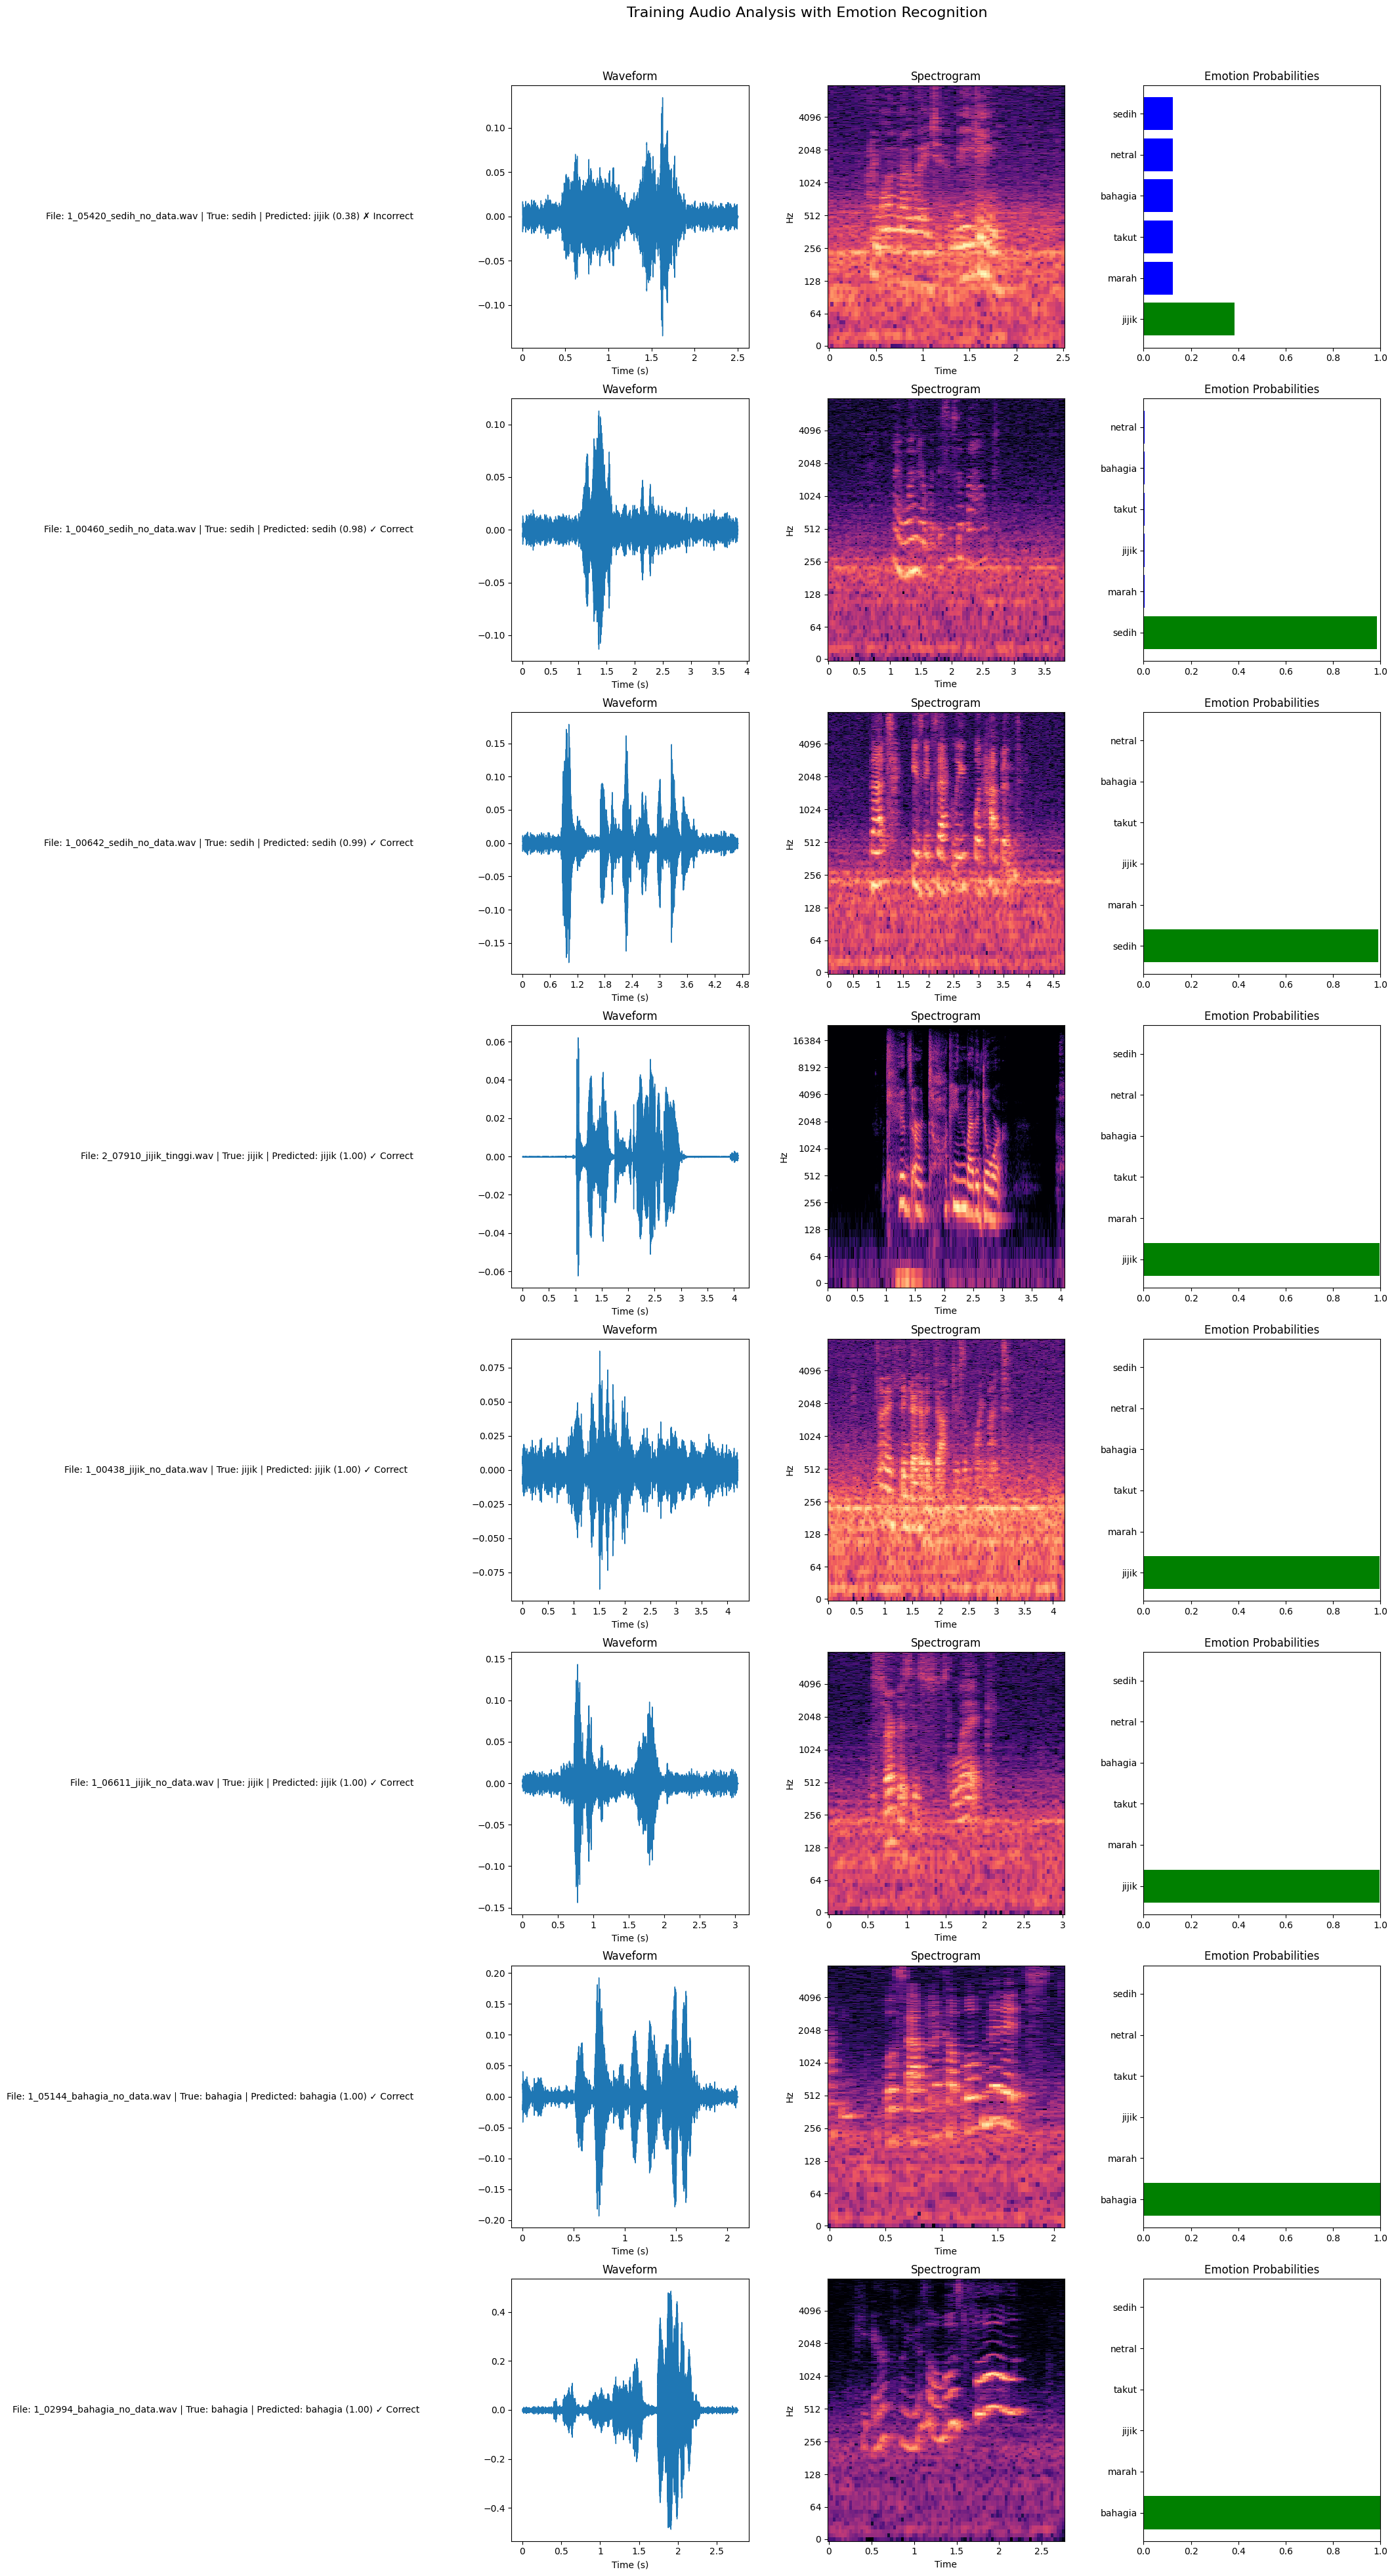

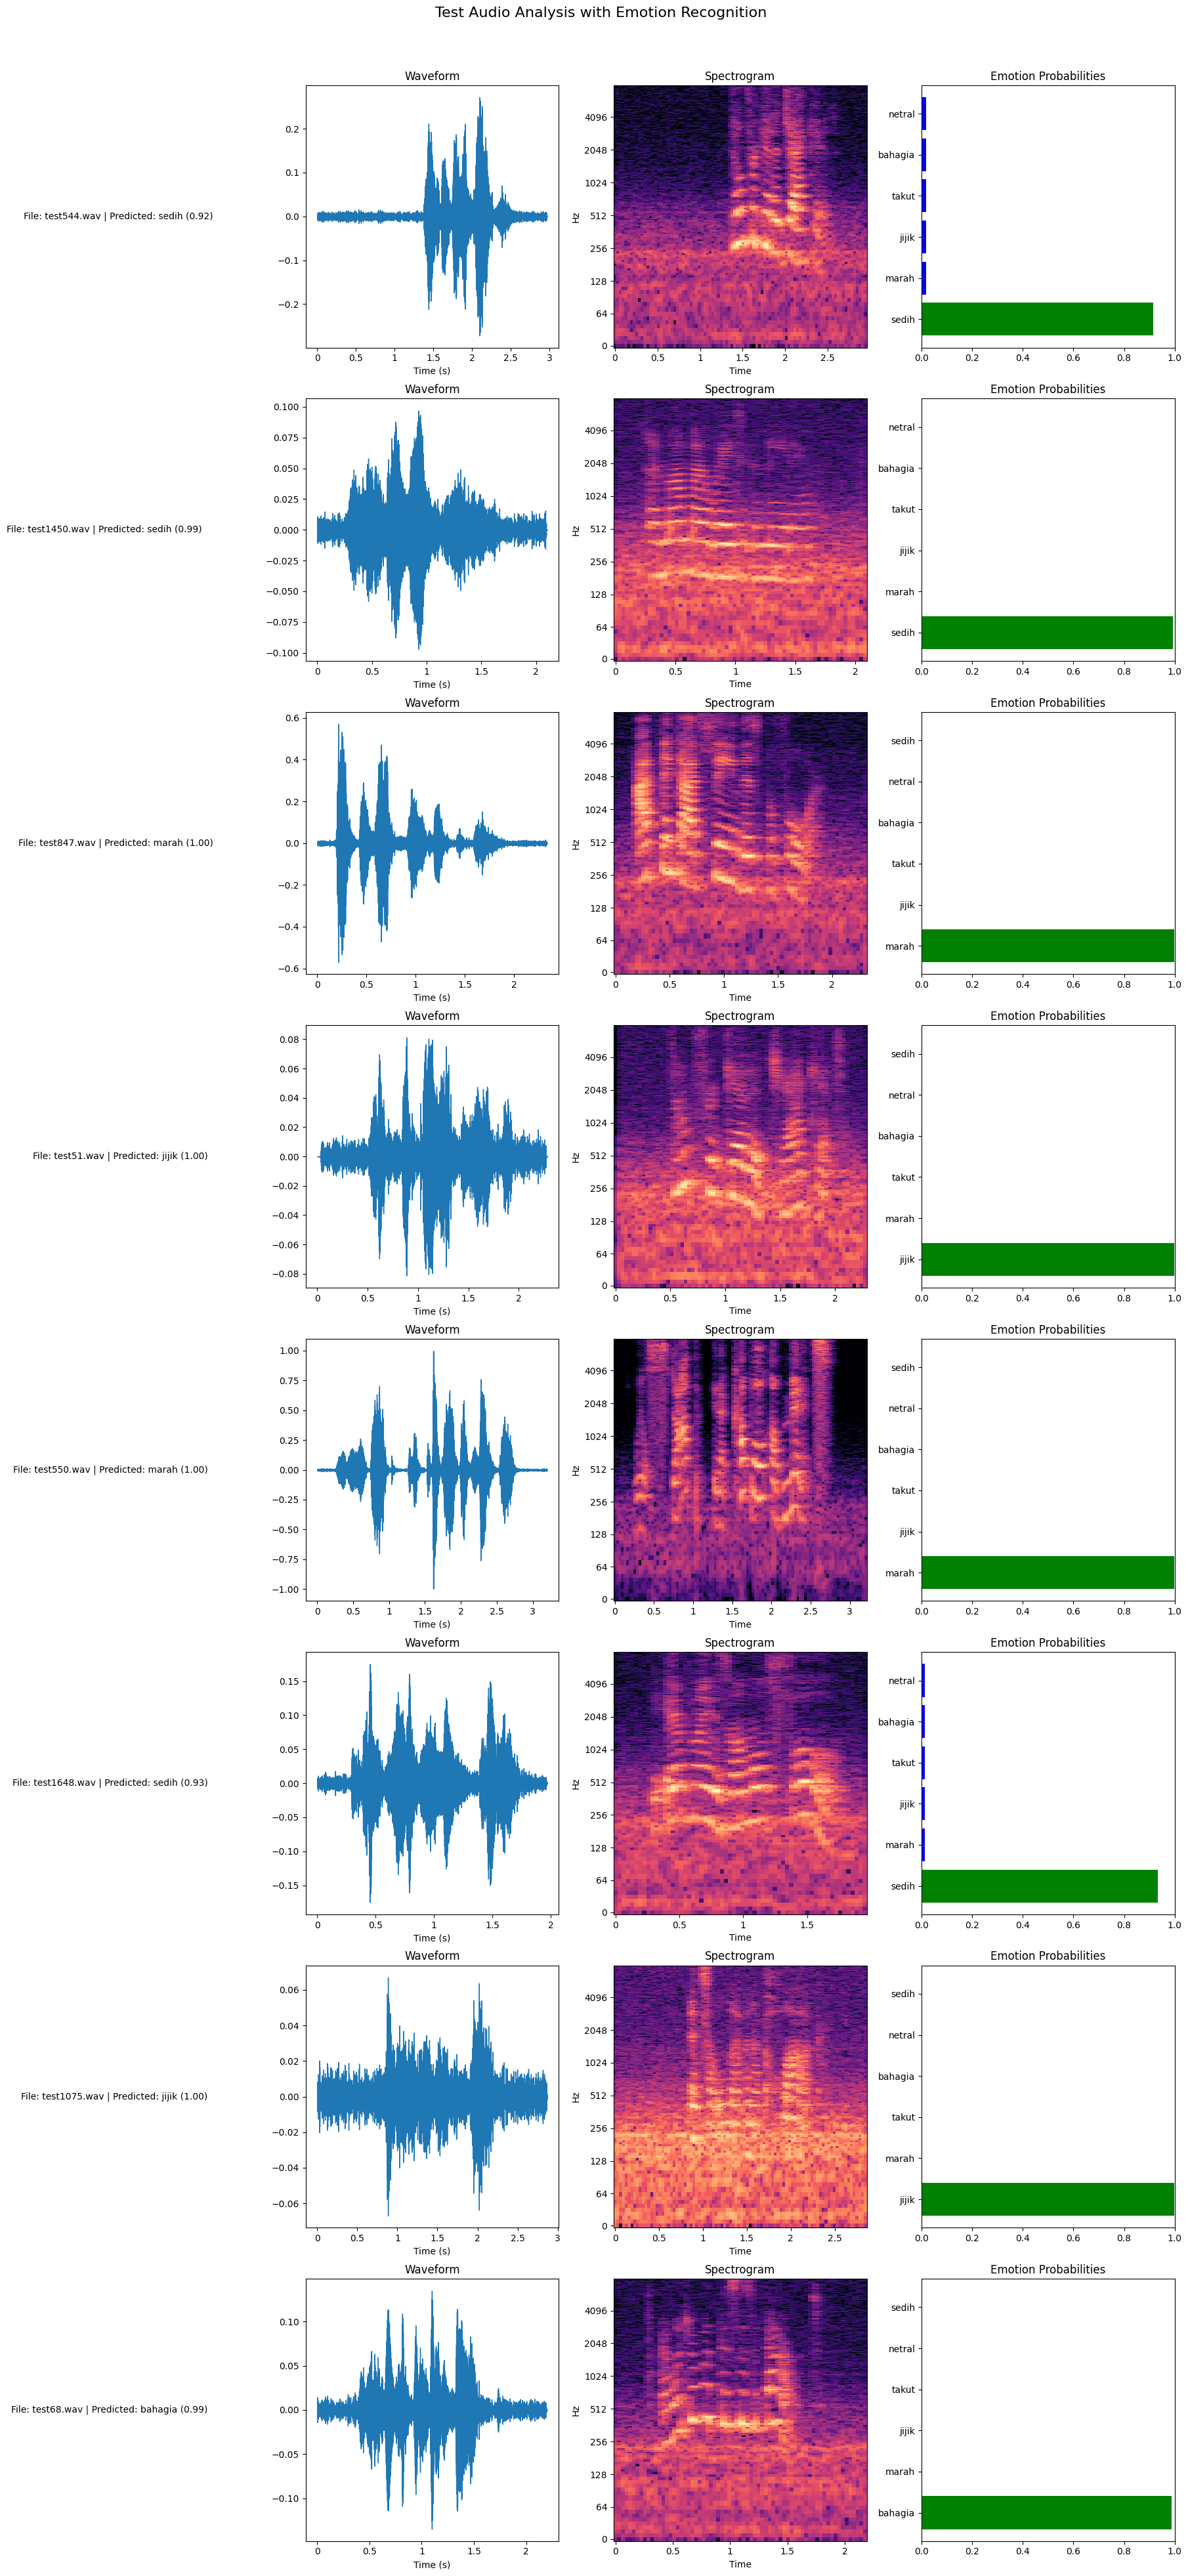

In [20]:
visualize_emotion_inference(
    model_path='/kaggle/working/emotion_model.pth',
    num_samples=3,
    csv_train_path='/kaggle/input/ser-train-test/train.csv',
    csv_test_path='/kaggle/input/ser-train-test/test.csv',
    train_dir='/kaggle/input/speech-emotion-recognition-dl/train',
    test_dir='/kaggle/input/speech-emotion-recognition-dl/test'
)